In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm # progress bar
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from pymongo import MongoClient
from sklearn.preprocessing import LabelEncoder

In [2]:
LISTE_MAJ = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]
LISTE_MIN = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]
LISTE_NBR = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

In [3]:
# shape of the image : 50x50
# number of classes : 62
# number of train images : 487_227
# number of test images : 155_489
# number of validation images : 155_686

# Get Data
---

- Récupération des données de la base de données
- formattage des données
- répartition des données

In [4]:
# Connexion à MongoDB
client = MongoClient("mongodb://localhost:27017/Scibio")  # Remplacez par l'URL de votre serveur MongoDB
db = client["Scribio"]  # Nom de la base de données
collection = db["Dataset"]  # Nom de la collection
# Temps : 0.0s

In [5]:
def fetch_data(repartition: str, nbr: int):
    query = {"Repartition": repartition}
    documents = collection.find(query)
    print(f"fetch {repartition} OK !!!")

    images = []
    labels = []
    types = []
    
    # Parcours et transformation des photos avec barre de progression 
    with tqdm(total=nbr, desc="Proccessing" , position=0, leave=True) as pbar:
        for doc in documents:
            images.append(np.array(doc["Tableau_Pixels"], dtype=np.float32))
            labels.append(doc["Label"])
            try:
                types.append(doc["Type"])
            except:
                if doc["Label"] in LISTE_MAJ:
                    types.append("Maj")
                elif doc["Label"] in LISTE_MIN:
                    types.append("Min")
                elif doc["Label"] in LISTE_NBR:
                    types.append("Nbr")
                else:
                    types.append("Auc")
            pbar.update(1) # Mettre à jour la barre de progression
            
    # return np.array(images), np.array(labels, dtype=str)
    return pd.DataFrame({"Labels": labels, "Types": types, "Images": images})

In [6]:
# Recupération des données d'entrainement depuis la base de données
df_train = fetch_data("train", 487_227)
print(df_train.shape) # (487_227, 3)
df_train.head()
# Temps : 5m 45.0s (en premier)

fetch train OK !!!


Proccessing: 100%|██████████| 487227/487227 [04:37<00:00, 1756.60it/s]

(487227, 3)


,Labels,Types,Images
0,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [7]:
# Mélanger les données d'entrainement
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_train.head()
# Temps : 0.0s

,Labels,Types,Images
0,4,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,S,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,7,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,O,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Z,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [8]:
# Recupération des données de test depuis la base de données
df_test = fetch_data("test", 155_489)
print(df_test.shape) # (155_489, 3)
df_test.head()
# Temps : 27min 17.5s (en deuxième)
# Temps : 7m 14.4s (en premier)

fetch test OK !!!


Proccessing: 100%|██████████| 155489/155489 [27:17<00:00, 94.95it/s]  

(155489, 3)


,Labels,Types,Images
0,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [9]:
# Mélanger les données de test
df_test = df_test.sample(frac=1).reset_index(drop=True)
df_test.head()
# Temps : 

,Labels,Types,Images
0,8,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,U,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,6,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,X,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,a,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [10]:
# Recupération des données de validation depuis la base de données
df_validation = fetch_data("validation", 155_686)
print(df_validation.shape) # (, 3)
df_validation.head()
# Temps : 45m 59.1s (en troisème)

fetch validation OK !!!


Proccessing: 100%|██████████| 155686/155686 [53:13<00:00, 48.75it/s]  

(155686, 3)


,Labels,Types,Images
0,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


# 

In [11]:
# Mélanger les données d'entrainement
df_validation = df_validation.sample(frac=1).reset_index(drop=True)
df_validation.head()
# Temps : 0.0s

,Labels,Types,Images
0,7,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,N,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,R,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,n,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,7,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Données pour apprentissage du NN 'Get type'
---

Préparation des données pour l'entrainement du réseau de neurones 'Get type' qui permettra de classé les images selon trois catégories :

- Majuscule
- Minuscule
- Nombre

In [12]:
X_train_types = np.array(df_train["Images"].tolist())
y_train_types = np.array(df_train["Types"].tolist())
X_test_types = np.array(df_test["Images"].tolist())
y_test_types = np.array(df_test["Types"].tolist())
X_validation_types = np.array(df_validation["Images"].tolist())
y_validation_types = np.array(df_validation["Types"].tolist())
# Temps : 11.8s

In [13]:
# Conversion des étiquettes en indices (si nécessaire)
label_encoder_types = LabelEncoder()

y_train_types_2 = label_encoder_types.fit_transform(y_train_types)  # Convertit les étiquettes (lettres/nombres) en indices numériques (nombre) (str => int)
y_test_types_2 = label_encoder_types.transform(y_test_types)
y_validation_types_2 = label_encoder_types.transform(y_validation_types)

In [14]:
# Correspondance indices ↔ labels
correspondance_types = dict(enumerate(label_encoder_types.classes_))
print(correspondance_types)

# Liste des labels
labels_types = list(correspondance_types.values())
print(labels_types)

{0: 'Maj', 1: 'Min', 2: 'Nbr'}
['Maj', 'Min', 'Nbr']


In [15]:
# Afficher quelques informations
print(f"Taille de X_train_types: {X_train_types.shape}, y_train_types: {y_train_types.shape}, y_train_types_2: {y_train_types_2.shape}")
print(f"Taille de X_test_types: {X_test_types.shape}, y_test_types: {y_test_types.shape}, y_test_types_2: {y_test_types_2.shape}")
print(f"Taille de X_validation_types: {X_validation_types.shape}, y_validation_types: {y_validation_types.shape}, y_validation_types_2: {y_validation_types_2.shape}")

Taille de X_train_types: (487227, 2500), y_train_types: (487227,), y_train_types_2: (487227,)
Taille de X_test_types: (155489, 2500), y_test_types: (155489,), y_test_types_2: (155489,)
Taille de X_validation_types: (155686, 2500), y_validation_types: (155686,), y_validation_types_2: (155686,)


### Données pour apprentissage du NN 'Get Maj'
---

Préparation des données pour l'entrainement du réseau de neurones 'Get Maj' qui permettra de classé les images selon la lettre majuscule qui y est representée.

In [16]:
df_train_Maj = df_train[df_train["Types"] == "Maj"]
print(df_train_Maj.shape) # (, 3)
df_train_Maj.head()
# Temps : 

(150341, 3)


,Labels,Types,Images
1,S,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,O,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Z,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,F,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,S,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [17]:
df_test_Maj = df_test[df_test["Types"] == "Maj"]
print(df_test_Maj.shape) # (, 3)
df_test_Maj.head()
# Temps :

(43121, 3)


,Labels,Types,Images
1,U,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,X,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,P,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
11,E,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
12,S,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [18]:
df_validation_Maj = df_validation[df_validation["Types"] == "Maj"]
print(df_validation_Maj.shape) # (, 3)
df_validation_Maj.head()
# Temps :

(43250, 3)


,Labels,Types,Images
1,N,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,R,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
10,P,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
18,G,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
19,R,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [19]:
X_train_Maj = np.array(df_train_Maj["Images"].tolist())
y_train_Maj = np.array(df_train_Maj["Labels"].tolist())
X_test_Maj = np.array(df_test_Maj["Images"].tolist())
y_test_Maj = np.array(df_test_Maj["Labels"].tolist())
X_validation_Maj = np.array(df_validation_Maj["Images"].tolist())
y_validation_Maj = np.array(df_validation_Maj["Labels"].tolist())
# Temps : 

In [20]:
# Conversion des étiquettes en indices (si nécessaire)
label_encoder_Maj = LabelEncoder()

y_train_Maj_2 = label_encoder_Maj.fit_transform(y_train_Maj)  # Convertit les étiquettes (lettres/nombres) en indices numériques (nombre) (str => int)
y_test_Maj_2 = label_encoder_Maj.transform(y_test_Maj)
y_validation_Maj_2 = label_encoder_Maj.transform(y_validation_Maj)

In [21]:
# Correspondance indices ↔ labels
correspondance_Maj = dict(enumerate(label_encoder_Maj.classes_))
print(correspondance_Maj)

# Liste des labels
labels_Maj = list(correspondance_Maj.values())
print(labels_Maj)

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [22]:
# Afficher quelques informations
print(f"Taille de X_train_Maj: {X_train_Maj.shape}, y_train_Maj: {y_train_Maj.shape}, y_train_Maj_2: {y_train_Maj_2.shape}")
print(f"Taille de X_test_Maj: {X_test_Maj.shape}, y_test_Maj: {y_test_Maj.shape}, y_test_Maj_2: {y_test_Maj_2.shape}")
print(f"Taille de X_validation_Maj: {X_validation_Maj.shape}, y_validation_Maj: {y_validation_Maj.shape}, y_validation_Maj_2: {y_validation_Maj_2.shape}")

Taille de X_train_Maj: (150341, 2500), y_train_Maj: (150341,), y_train_Maj_2: (150341,)
Taille de X_test_Maj: (43121, 2500), y_test_Maj: (43121,), y_test_Maj_2: (43121,)
Taille de X_validation_Maj: (43250, 2500), y_validation_Maj: (43250,), y_validation_Maj_2: (43250,)


### Données pour apprentissage du NN 'Get Min'
---

Préparation des données pour l'entrainement du réseau de neurones 'Get Min' qui permettra de classé les images selon la lettre minuscule qui y est representée.

In [23]:
df_train_Min = df_train[df_train["Types"] == "Min"]
print(df_train_Min.shape) # (, 3)
df_train_Min.head()
# Temps : 

(111713, 3)


,Labels,Types,Images
8,b,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
15,d,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
19,t,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
24,d,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
29,b,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [24]:
df_test_Min = df_test[df_test["Types"] == "Min"]
print(df_test_Min.shape) # (, 3)
df_test_Min.head()
# Temps :

(37358, 3)


,Labels,Types,Images
4,a,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,e,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,a,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
15,n,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
18,d,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [25]:
df_validation_Min = df_validation[df_validation["Types"] == "Min"]
print(df_validation_Min.shape) # (, 3)
df_validation_Min.head()
# Temps :

(37374, 3)


,Labels,Types,Images
3,n,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,t,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,r,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
13,t,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
23,e,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [26]:
X_train_Min = np.array(df_train_Min["Images"].tolist())
y_train_Min = np.array(df_train_Min["Labels"].tolist())
X_test_Min = np.array(df_test_Min["Images"].tolist())
y_test_Min = np.array(df_test_Min["Labels"].tolist())
X_validation_Min = np.array(df_validation_Min["Images"].tolist())
y_validation_Min = np.array(df_validation_Min["Labels"].tolist())
# Temps : 1.3s

In [27]:
# Conversion des étiquettes en indices (si nécessaire)
label_encoder_Min = LabelEncoder()

y_train_Min_2 = label_encoder_Min.fit_transform(y_train_Min)  # Convertit les étiquettes (lettres/nombres) en indices numériques (nombre) (str => int)
y_test_Min_2 = label_encoder_Min.transform(y_test_Min)
y_validation_Min_2 = label_encoder_Min.transform(y_validation_Min)

In [28]:
# Correspondance indices ↔ labels
correspondance_Min = dict(enumerate(label_encoder_Min.classes_))
print(correspondance_Min)

# Liste des labels
labels_Min = list(correspondance_Min.values())
print(labels_Min)

{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z'}
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [29]:
# Afficher quelques informations
print(f"Taille de X_train_Min: {X_train_Min.shape}, y_train_Min: {y_train_Min.shape}, y_train_Min_2: {y_train_Min_2.shape}")
print(f"Taille de X_test_Min: {X_test_Min.shape}, y_test_Min: {y_test_Min.shape}, y_test_Min_2: {y_test_Min_2.shape}")
print(f"Taille de X_validation_Min: {X_validation_Min.shape}, y_validation_Min: {y_validation_Min.shape}, y_validation_Min_2: {y_validation_Min_2.shape}")

Taille de X_train_Min: (111713, 2500), y_train_Min: (111713,), y_train_Min_2: (111713,)
Taille de X_test_Min: (37358, 2500), y_test_Min: (37358,), y_test_Min_2: (37358,)
Taille de X_validation_Min: (37374, 2500), y_validation_Min: (37374,), y_validation_Min_2: (37374,)


### Données pour apprentissage du NN 'Get Nbr'
---

Préparation des données pour l'entrainement du réseau de neurones 'Get Nbr' qui permettra de classé les images selon le chiffre qui y est représenté.

In [30]:
df_train_Nbr = df_train[df_train["Types"] == "Nbr"]
print(df_train_Nbr.shape) # (, 3)
df_train_Nbr.head()
# Temps : 

(225173, 3)


,Labels,Types,Images
0,4,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,7,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,2,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
13,6,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
14,1,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [31]:
df_test_Nbr = df_test[df_test["Types"] == "Nbr"]
print(df_test_Nbr.shape) # (, 3)
df_test_Nbr.head()
# Temps : 

(75010, 3)


,Labels,Types,Images
0,8,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,6,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,0,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,3,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
10,2,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [32]:
df_validation_Nbr = df_validation[df_validation["Types"] == "Nbr"]
print(df_validation_Nbr.shape) # (, 3)
df_validation_Nbr.head()
# Temps : 

(75062, 3)


,Labels,Types,Images
0,7,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,7,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,0,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,9,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,5,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [33]:
X_train_Nbr = np.array(df_train_Nbr["Images"].tolist())
y_train_Nbr = np.array(df_train_Nbr["Labels"].tolist())
X_test_Nbr = np.array(df_test_Nbr["Images"].tolist())
y_test_Nbr = np.array(df_test_Nbr["Labels"].tolist())
X_validation_Nbr = np.array(df_validation_Nbr["Images"].tolist())
y_validation_Nbr = np.array(df_validation_Nbr["Labels"].tolist())
# Temps : 9.1s

In [34]:
# Conversion des étiquettes en indices (si nécessaire)
label_encoder_Nbr = LabelEncoder()

y_train_Nbr_2 = label_encoder_Nbr.fit_transform(y_train_Nbr)  # Convertit les étiquettes (lettres/nombres) en indices numériques (nombre) (str => int)
y_test_Nbr_2 = label_encoder_Nbr.transform(y_test_Nbr)
y_validation_Nbr_2 = label_encoder_Nbr.transform(y_validation_Nbr)

In [35]:
# Correspondance indices ↔ labels
correspondance_Nbr = dict(enumerate(label_encoder_Nbr.classes_))
print(correspondance_Nbr)

# Liste des labels
labels_Nbr = list(correspondance_Nbr.values())
print(labels_Nbr)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9'}
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [36]:
# Afficher quelques informations
print(f"Taille de X_train_Nbr: {X_train_Nbr.shape}, y_train_Nbr: {y_train_Nbr.shape}, y_train_Nbr_2: {y_train_Nbr_2.shape}")
print(f"Taille de X_test_Nbr: {X_test_Nbr.shape}, y_test_Nbr: {y_test_Nbr.shape}, y_test_Nbr_2: {y_test_Nbr_2.shape}")
print(f"Taille de X_validation_Nbr: {X_validation_Nbr.shape}, y_validation_Nbr: {y_validation_Nbr.shape}, y_validation_Nbr_2: {y_validation_Nbr_2.shape}")

Taille de X_train_Nbr: (225173, 2500), y_train_Nbr: (225173,), y_train_Nbr_2: (225173,)
Taille de X_test_Nbr: (75010, 2500), y_test_Nbr: (75010,), y_test_Nbr_2: (75010,)
Taille de X_validation_Nbr: (75062, 2500), y_validation_Nbr: (75062,), y_validation_Nbr_2: (75062,)


# Get Type (NN)
---

Modèle ...

In [99]:
# Reseau de neurones
model_get_type = keras.Sequential([
    keras.layers.Input((2500,)), # input layer : 2500 neurones (50x50 pixels)
    keras.layers.Dense(625, activation='relu'),
    keras.layers.Dense(156, activation='relu'),
    keras.layers.Dense(40, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(3, activation='softmax') # output layer : 3 neurones (Maj, Min, Nbr) -> softmax : sortie à 3 classes
])

model_get_type.compile(
    optimizer='adam', # optimizer : Adam avec learning rate de 0.0001
    loss='sparse_categorical_crossentropy', # loss : sparse_categorical_crossentropy pour la classification
    metrics=['accuracy'] # metrics : accuracy pour évaluer la performance du modèle
)

In [ ]:
model_get_type.fit(
    X_train_types, 
    y_train_types_2, 
    epochs=10, 
    batch_size=256, 
    validation_data=(
        X_validation_types, 
        y_validation_types_2
    ),
    verbose=1
)

# Batch 32
# accuracy : 0.8618
# loss : 0.3311
# Temps : 16m 33.5s

# Batch 64
# accuracy : 0.8644
# loss : 0.3228
# Temps : 8m 41s

# Batch 128
# accuracy : 0.8654
# loss : 0.3209
# Temps : 4m 35.4s

# Batch 256
# accuracy : 0.8644
# loss : 0.3220
# Temps : 2m 46.5s

Epoch 1/10
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.7557 - loss: 0.5737 - val_accuracy: 0.8160 - val_loss: 0.4386
Epoch 2/10
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.8272 - loss: 0.4166 - val_accuracy: 0.8256 - val_loss: 0.4185
Epoch 3/10
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8385 - loss: 0.3892 - val_accuracy: 0.8309 - val_loss: 0.4082
Epoch 4/10
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8446 - loss: 0.3728 - val_accuracy: 0.8337 - val_loss: 0.4013
Epoch 5/10
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.8504 - loss: 0.3595 - val_accuracy: 0.8359 - val_loss: 0.3961
Epoch 6/10
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8533 - loss: 0.3506 - val_accuracy: 0.8379 - val_loss: 0.3922
Epoch 7/10
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.8581 - loss: 0.3413 - val_accuracy: 0.8375 - val_loss: 0.3950
Epoch 8/10
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.8605 - loss: 0

In [101]:
test_loss_type, test_acc_type = model_get_type.evaluate(X_test_types, y_test_types_2)
print(f"Test accuracy : {test_acc_type}") # Test accuracy : 
print(f"Test loss : {test_loss_type}") # Test loss : 
# Temps : 8.3s

4860/4860 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8407 - loss: 0.3939
Test accuracy : 0.8401044607162476
Test loss : 0.39449504017829895


In [102]:
# Sauvegarder le modèle
model_get_type.save("../models/Get_type_b256.keras")  # Format HDF5 (.h5)

In [103]:
y_predicted_types = model_get_type.predict(X_test_types)
y_predicted_types[1]
# Temps : 7.2s

4860/4860 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


array([9.9579054e-01, 4.2084213e-03, 1.0341505e-06], dtype=float32)

In [104]:
np.argmax(y_predicted_types[1])

0

In [105]:
# y_predicted_labels1 = np.array([correspondance_types[np.argmax(i)] for i in y_predicted_types])
y_predicted_labels_types = [np.argmax(i) for i in y_predicted_types]
y_predicted_labels_types[:5]

[2, 0, 2, 1, 1]

In [106]:
y_test_types_2[:5]

array([2, 0, 2, 0, 1])

Text(95.72222222222221, 0.5, 'Truth')

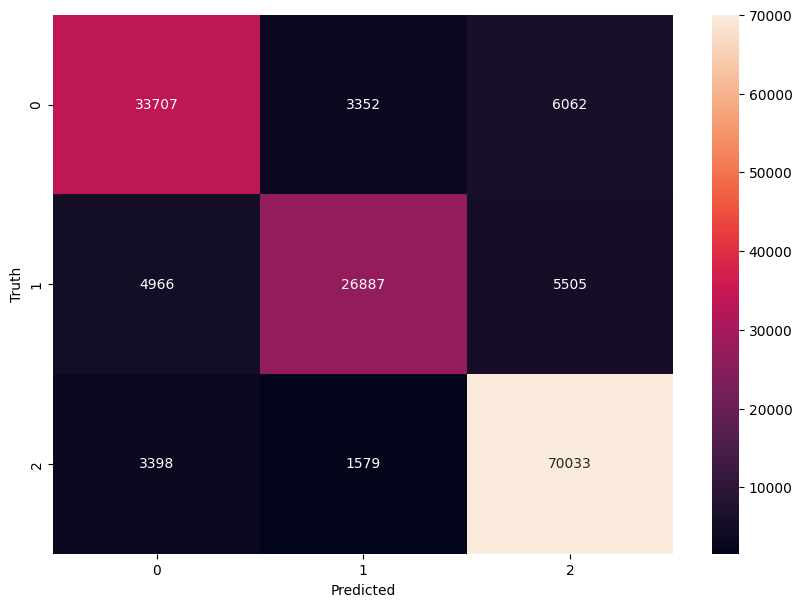

In [107]:
# Matrice de confusion
cm_types = tf.math.confusion_matrix(labels=y_test_types_2, predictions=y_predicted_labels_types)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_types, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Get Maj (NN)
---

Modèle ...

In [108]:
model_get_maj = keras.Sequential([
    keras.layers.Input((2500,)), # input layer : 2500 neurones (50x50 pixels)
    keras.layers.Dense(625, activation='relu'),
    keras.layers.Dense(156, activation='relu'),
    keras.layers.Dense(40, activation='relu'),
    keras.layers.Dense(26, activation='sigmoid') # output layer : 26 neurones (A-Z)
])

model_get_maj.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model_get_maj.fit(
    X_train_Maj, 
    y_train_Maj_2, 
    epochs=10, 
    batch_size=256, 
    validation_data=(
        X_validation_Maj, 
        y_validation_Maj_2
    ),
    verbose=1
)

# Batch 32
# accuracy : 0.9508
# loss : 0.1701
# Temps : 5m 17.7s

# Batch 64
# accuracy : 0.9522
# loss : 0.1632
# Temps : 2m 18.6s

# Batch 128
# accuracy : 0.9558
# loss : 0.1531
# Temps : 1m 19.8s

# Batch 256
# accuracy : 0.9527
# loss : 0.1621
# Temps : 51.7s

Epoch 1/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7473 - loss: 0.9557 - val_accuracy: 0.9100 - val_loss: 0.3552
Epoch 2/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9182 - loss: 0.3087 - val_accuracy: 0.9249 - val_loss: 0.2877
Epoch 3/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9299 - loss: 0.2562 - val_accuracy: 0.9274 - val_loss: 0.2757
Epoch 4/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9387 - loss: 0.2226 - val_accuracy: 0.9270 - val_loss: 0.2759
Epoch 5/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9437 - loss: 0.2012 - val_accuracy: 0.9265 - val_loss: 0.2771
Epoch 6/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9462 - loss: 0.1912 - val_accuracy: 0.9299 - val_loss: 0.2687
Epoch 7/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9478 - loss: 0.1824 - val_accuracy: 0.9315 - val_loss: 0.2648
Epoch 8/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9504 - loss: 0.1707 - val_accuracy: 0.

In [110]:
test_loss_maj, test_acc_maj = model_get_maj.evaluate(X_test_Maj, y_test_Maj_2)
print(f"Test accuracy : {test_acc_maj}") # Test accuracy : 
print(f"Test loss : {test_loss_maj}") # Test loss : 
# Temps : 1.9s

1348/1348 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9347 - loss: 0.2630
Test accuracy : 0.9345098733901978
Test loss : 0.26259076595306396


In [111]:
# Sauvegarder le modèle
model_get_maj.save("../models/Get_Maj_b256.keras")  # Format HDF5 (.h5)

In [112]:
y_predicted_Maj = model_get_maj.predict(X_test_Maj)
y_predicted_Maj[1]
# Temps 1.8s

1348/1348 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


array([4.4966961e-05, 5.2595860e-01, 3.4315937e-05, 2.0425653e-02,
       4.8692153e-05, 5.8566488e-02, 2.9908317e-05, 6.8029069e-04,
       3.9785635e-01, 1.1907098e-02, 8.5925114e-01, 3.5390934e-01,
       4.6556019e-05, 1.0218046e-02, 7.0336115e-05, 3.0636111e-01,
       3.3062506e-03, 3.0974742e-02, 4.7138172e-01, 1.6916450e-02,
       8.2797259e-01, 3.1631607e-01, 5.3622123e-05, 1.0000000e+00,
       9.9764389e-01, 7.3374767e-04], dtype=float32)

In [113]:
np.argmax(y_predicted_Maj[1])

23

In [114]:
# y_predicted_labels_Maj = [correspondance_Maj[np.argmax(i)] for i in y_predicted_Maj]
y_predicted_labels_Maj = [np.argmax(i) for i in y_predicted_Maj]
y_predicted_labels_Maj[:5]

[20, 23, 15, 4, 18]

Text(95.72222222222221, 0.5, 'Truth')

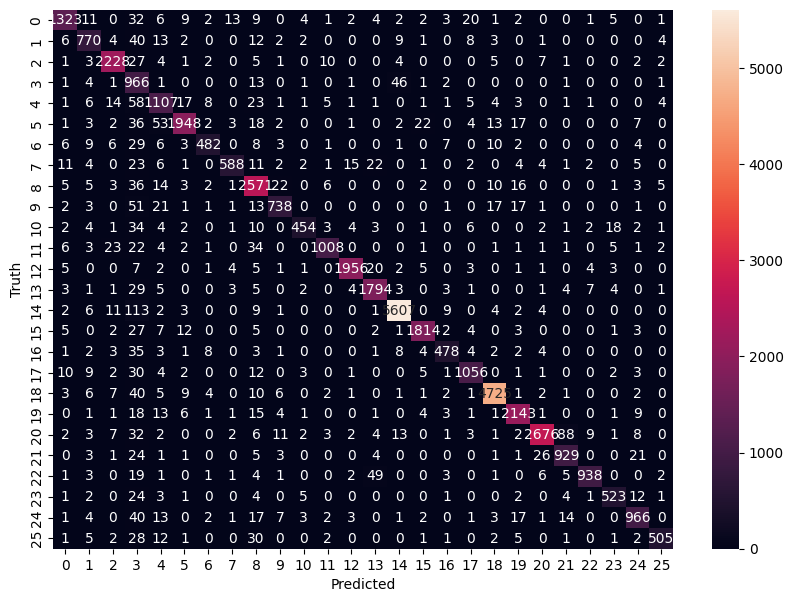

In [115]:
# Matrice de confusion
cm_Maj = tf.math.confusion_matrix(labels=y_test_Maj_2, predictions=y_predicted_labels_Maj)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_Maj, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Get Min (NN)
---

Modèle ...

In [116]:
model_get_min = keras.Sequential([
    keras.layers.Input((2500,)), # input layer : 2500 neurones (50x50 pixels)
    keras.layers.Dense(625, activation='relu'),
    keras.layers.Dense(156, activation='relu'),
    keras.layers.Dense(40, activation='relu'),
    keras.layers.Dense(26, activation='sigmoid') # output layer : 26 neurones (A-Z)
])

model_get_min.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model_get_min.fit(
    X_train_Min, 
    y_train_Min_2, 
    epochs=10, 
    batch_size=256, 
    validation_data=(
        X_validation_Min, 
        y_validation_Min_2
    ),
    verbose=1
)

# Batch 32
# accuracy : 0.9293
# loss : 0.2193
# Temps : 2m 45.3s

# Batch 64
# accuracy : 0.9328
# loss : 0.2042
# Temps : 2m 2.7s

# Batch 128
# accuracy : 0.9332
# loss : 0.2038
# Temps : 58.4s

# Batch 256
# accuracy : 0.9338
# loss : 0.2036
# Temps : 38.3s

Epoch 1/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7166 - loss: 1.1020 - val_accuracy: 0.8729 - val_loss: 0.4533
Epoch 2/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8853 - loss: 0.3984 - val_accuracy: 0.8918 - val_loss: 0.3775
Epoch 3/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9030 - loss: 0.3329 - val_accuracy: 0.8954 - val_loss: 0.3579
Epoch 4/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9120 - loss: 0.2946 - val_accuracy: 0.8958 - val_loss: 0.3587
Epoch 5/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9173 - loss: 0.2681 - val_accuracy: 0.8990 - val_loss: 0.3486
Epoch 6/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9223 - loss: 0.2518 - val_accuracy: 0.8978 - val_loss: 0.3476
Epoch 7/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9266 - loss: 0.2339 - val_accuracy: 0.9026 - val_loss: 0.3387
Epoch 8/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9291 - loss: 0.2238 - val_accuracy: 0.

In [118]:
test_loss_min, test_acc_min = model_get_min.evaluate(X_test_Min, y_test_Min_2)
print(f"Test accuracy : {test_acc_min}") # Test accuracy : 
print(f"Test loss : {test_loss_min}") # Test loss : 
# Temps : 

1168/1168 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9033 - loss: 0.3468
Test accuracy : 0.9012795090675354
Test loss : 0.35665667057037354


In [119]:
# Sauvegarder le modèle
model_get_min.save("../models/Get_Min_b256.keras")  # Format keras (.keras)

In [120]:
y_predicted_Min = model_get_min.predict(X_test_Min)
y_predicted_Min[1]

1168/1168 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


array([5.9035546e-01, 9.7117275e-01, 9.2190164e-01, 4.1890580e-02,
       9.9999934e-01, 2.8666988e-01, 7.1529663e-01, 1.8013838e-03,
       7.5455479e-02, 4.3689166e-03, 1.4060725e-01, 5.3666425e-01,
       1.0300325e-05, 4.7124522e-03, 1.3229237e-02, 1.2714712e-01,
       6.9835389e-01, 8.4855187e-01, 1.8895514e-01, 9.7830892e-01,
       6.5506492e-03, 1.1652083e-02, 3.9213101e-05, 7.6142787e-03,
       8.8577509e-02, 9.3476719e-01], dtype=float32)

In [121]:
# y_predicted_labels_Min = [correspondance_Min[np.argmax(i)] for i in y_predicted_Min]
y_predicted_labels_Min = [np.argmax(i) for i in y_predicted_Min]
y_predicted_labels_Min[:5]

[0, 4, 0, 13, 3]

Text(95.72222222222221, 0.5, 'Truth')

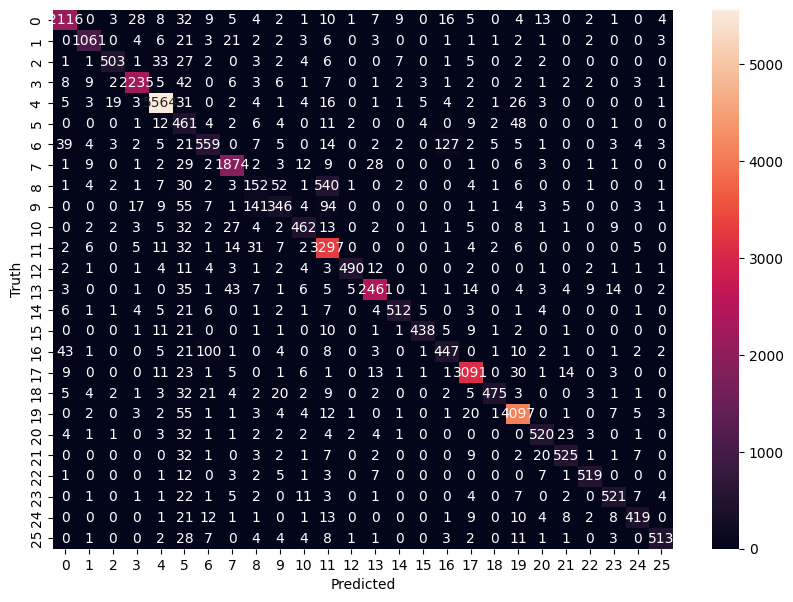

In [122]:
# Matrice de confusion
cm_Min = tf.math.confusion_matrix(labels=y_test_Min_2, predictions=y_predicted_labels_Min)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_Min, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Get Nbr (NN)
---

Modèle ...

In [123]:
model_get_nbr = keras.Sequential([
    keras.layers.Input((2500,)), # input layer : 2500 neurones (50x50 pixels)
    keras.layers.Dense(625, activation='relu'),
    keras.layers.Dense(156, activation='relu'),
    keras.layers.Dense(40, activation='relu'),
    keras.layers.Dense(26, activation='sigmoid') # output layer : 26 neurones (A-Z)
])

model_get_nbr.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model_get_nbr.fit(
    X_train_Nbr, 
    y_train_Nbr_2, 
    epochs=10, 
    batch_size=256,
    validation_data=(
        X_validation_Nbr, 
        y_validation_Nbr_2
    ),
    verbose=1
)

# Batch 32
# accuracy : 0.9325
# loss : 0.1897
# Temps : 6m 16.0s

# Batch 64
# accuracy : 0.9347
# loss : 0.1844
# Temps : 4m 16.6s

# Batch 128
# accuracy : 0.9343
# loss : 0.1834
# Temps : 1m 59.6s

# Batch 256
# accuracy : 0.9342
# loss : 0.1825
# Temps : 1m 16.2s

Epoch 1/10
880/880 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8496 - loss: 0.5230 - val_accuracy: 0.9209 - val_loss: 0.2403
Epoch 2/10
880/880 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9215 - loss: 0.2355 - val_accuracy: 0.9238 - val_loss: 0.2260
Epoch 3/10
880/880 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9269 - loss: 0.2141 - val_accuracy: 0.9235 - val_loss: 0.2260
Epoch 4/10
880/880 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9277 - loss: 0.2084 - val_accuracy: 0.9254 - val_loss: 0.2177
Epoch 5/10
880/880 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9295 - loss: 0.2001 - val_accuracy: 0.9274 - val_loss: 0.2133
Epoch 6/10
880/880 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9312 - loss: 0.1943 - val_accuracy: 0.9267 - val_loss: 0.2163
Epoch 7/10
880/880 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9328 - loss: 0.1896 - val_accuracy: 0.9256 - val_loss: 0.2225
Epoch 8/10
880/880 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9326 - loss: 0.1882 - val_accuracy: 0.

In [125]:
test_loss_nbr, test_acc_nbr = model_get_nbr.evaluate(X_test_Nbr, y_test_Nbr_2)
print(f"Test accuracy : {test_acc_nbr}") # Test accuracy : 
print(f"Test loss : {test_loss_nbr}") # Test loss : 
# Temps : 3.0s

2345/2345 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9270 - loss: 0.2195
Test accuracy : 0.9269164204597473
Test loss : 0.2212202399969101


In [126]:
# Sauvegarder le modèle
model_get_nbr.save("../models/Get_Nbr_b256.keras")  # Format keras (.keras)

In [127]:
y_predicted_Nbr = model_get_nbr.predict(X_test_Nbr)
y_predicted_Nbr[1]
# Temps : 3.4s

2345/2345 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


array([9.9996060e-01, 1.1053688e-02, 9.2244041e-01, 9.4952154e-01,
       9.3979239e-01, 9.8952442e-01, 1.0000000e+00, 2.2995542e-03,
       9.9256873e-01, 1.7366345e-01, 3.0165398e-16, 1.0909468e-11,
       6.0325204e-15, 8.7041077e-12, 2.6861522e-15, 1.2222526e-14,
       2.9563044e-20, 4.2663978e-18, 3.6837082e-17, 5.9191191e-21,
       1.9959212e-21, 4.2729230e-21, 1.5715228e-12, 2.5685016e-12,
       3.4318953e-22, 4.4440609e-17], dtype=float32)

In [128]:
# y_predicted_labels_Nbr = [correspondance_Nbr[np.argmax(i)] for i in y_predicted_Nbr]
y_predicted_labels_Nbr = [np.argmax(i) for i in y_predicted_Nbr]
y_predicted_labels_Nbr[:5]

[8, 6, 0, 1, 2]

Text(95.72222222222221, 0.5, 'Truth')

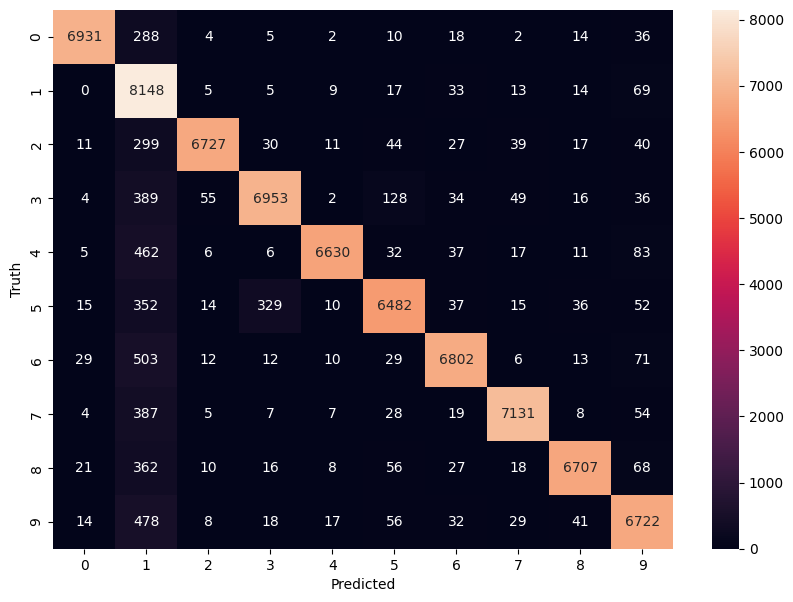

In [129]:
# Matrice de confusion
cm_Nbr = tf.math.confusion_matrix(labels=y_test_Nbr_2, predictions=y_predicted_labels_Nbr)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_Nbr, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')